# Spoken Language Processing - Instituto Superior Técnico
## Laboratory Assignment 2 - Native Language Identification challenge

# PART 1 - Classical models based on conventional features


This notebook contains the guide and code cells (some of them partially incomplete) that permit implementing a baseline system for native language identification based on conventional feeatures and a simple generative model. Besides, the notebook will show how to obtain predictions and  score the systems on the development set. 

**Read carefully the Markdown information, but also the comments inside the code cells (they provide useful information and hints), and also the code itself. The better you understand it, the easier will be modyfing it.**

## Before starting

Like in the introduction Notebook, we'll import the dummy Exception class:

In [1]:
from pf_tools import CheckThisCell

And  you need to mount Google drive if you are working on Google Colab. If you are note using Google Colab, skip or delete the following code cell:

In [2]:
# raise CheckThisCell ## <---- Remove this torun this cell if you are on Google Colab
# from google.colab import drive
# drive.mount('/content/drive')


And set-up your working directory:

In [2]:
# raise CheckThisCell ## <---- Remove this after completeing/checking this cell
import os 

CWD = os.getcwd() # <--- Change this variable to your working directory 
DATADIR = f'{CWD}/ets_data/' # <--- Change this variable to your folder containig the ETS data
if not os.path.isdir(DATADIR):
    os.mkdir(DATADIR)

os.chdir(CWD)
print(f'Current working directory is set to {CWD}')   
print(f'Your ETS data folder is {DATADIR}')


Current working directory is set to d:\Lovaion\University\2nd Year\Erasmus\Spoken Language Processing\Lab\Assignment2
Your ETS data folder is d:\Lovaion\University\2nd Year\Erasmus\Spoken Language Processing\Lab\Assignment2/ets_data/


## 1. The MFCC and GMM baseline system 
This baseline consists of MFCC feature extraction  (based on the `librosa` module) with the following (optional) additional commponents:
- Delta and Double-delta computation;
- Shifted Delta Cepstrum (SDC), an alternative to deltas used in language classification;
- Voice Activity Detection (VAD);
- Cepstral mean and variance normalization (CMVN).

The feature extraction module is followed by GMMs of 64 dimensions for each language (using the `sklearn` module). 

Student groups will be graded depending on their ability to develop the different modules, propose alternatives, and evaluate and compare different configurations (delta vs SDC, GMM dimension, using or not using VAD or CMVN, etc.)

### 1.1 Initialization and importing modules

In [3]:
import os
from pf_tools import ETS
import librosa
import numpy as np
import torch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

import time
import random
import datetime
from pathlib import Path
import pickle
import csv 
from tqdm import tqdm

GLOBAL_SEED = 35731

np.random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)


LANGUAGES = ('CHI',  'GER',  'HIN',  'ITA')
LANG2ID = {'CHI':1, 'GER':2, 'HIN':3, 'ITA':4}
ID2LANG = dict((LANG2ID[k],k)for k in LANG2ID)

### 1.2 The MFCC feature extraction module
The next function extracts MFCCs, but there are plenty of things that can be improved. You are free to change anything you want, including the number of formal parameters. 

In [4]:
# Read carefully this function and understand it

def feat_extract(filename, orig_sr=16000, mono=True, n_mfcc = 13, remove_c0=False, delta_order=0, apply_sdc=False, apply_vad=False, apply_cmvn=False, skip_frames=2):
    
    sr=16000
    n_mels = 40
    n_fft = 512 
    hop_length = 160
    fmin = 50
    fmax = 7800
    
    # Both delta and sdc are not possible
    if apply_sdc and (delta_order > 0):
        raise ValueError("Applying SDC and delta > 0 is not compatible")


    # Load audio wav into numpy array
    y, _ = librosa.load(filename, sr=orig_sr, mono=mono)
    
    # Resample in case it's needed
    if orig_sr != sr:
        y = librosa.resample(y, orig_sr=orig_sr,target_sr=sr)

    ## OPTIONAL ADDIDITIONAL STAGES 
    # 0 - PREPROCESSING - Typical preprocessing may include normalization of audio (mean removal), 
    #                       but also speech enhancement and others more complex. 
    #                       You can try this at a later stage, this is 100% optional

    # Extract MFFCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, 
                                n_mfcc=n_mfcc, n_mels=n_mels, 
                                hop_length=hop_length, 
                                fmin=fmin, fmax=fmax, htk=False).T
    
    
    ## ADDIDITIONAL STAGES - LAB WORK

    # 1 Compute deltas --> Hint you can use librosa (see below)
    if delta_order > 0:
        mfcc = compute_delta(mfcc, delta_order=delta_order)
        
    
    # 2 SDC --> Hint: You can build this using deltas (of extented context)  
    if apply_sdc:
        mfcc = compute_sdc(mfcc)
    
    # 3 COMPUTE VAD --> Hint: You can use any vad (theshold on rms energy, something avaialble in the net, ...).
    #                         Coeff0 of MFCC is highly related with Energy and it can be used as a proxy
    #                   ATTENTION: Using a VAD may have a significant impact  
    if apply_vad:
        mfcc, _ = compute_vad(mfcc)
             
    # 4 APPLY CMVN --> ATTENTION: Using normalization may have a significant impact
    if apply_cmvn:
        mfcc = compute_cmvn(mfcc)
        
    if skip_frames > 0: # remove begining and ending frames, which are tupically unreliable
        mfcc = mfcc[skip_frames:-skip_frames]

    return mfcc, y


Before implementing the additional modules, let's extract MFCCs of one audio file using `feat_extract`. Notice that this function returns two arguments: an array containing the features and the audio waveform.

[Text(0.5, 1.0, 'MFCC')]

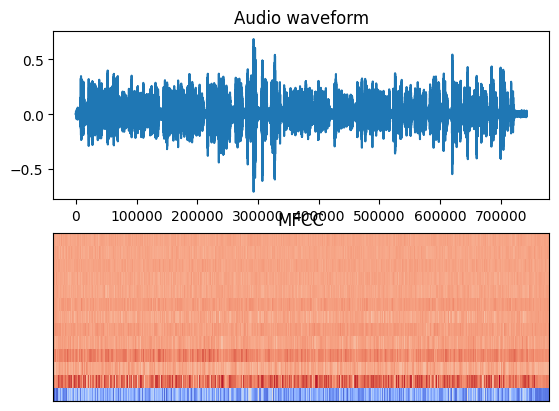

In [11]:
audio_file = f'{DATADIR}/train100/audio/train_0005.wav'
mfcc, audio = feat_extract(audio_file, apply_cmvn=False, apply_sdc=False)

# We can plot the audio waveform and the features
fig, ax = plt.subplots(nrows=2, sharex=False)
ax[0].plot(audio)
ax[0].set(title='Audio waveform')

# notice the transposition before calling the display: librosa expects arrays of DxT, in which T is time, 
# however our feature extraction returns arrays of TxD
img = librosa.display.specshow(mfcc.T,  ax=ax[1])
# fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')


Inspect the output arrays and confirm they have the expected dimension (use `audio.shape` and `mfcc.shape`). What is the relation among the dimensions of audio and mfcc?

In [7]:
# raise CheckThisCell ## <---- Remove this after completing/checking this cell
audio.shape, mfcc.shape

# ((742400,), (4637, 13))
# this is the expected output, that is the shape of the audio and the shape of the mfcc features.
# 742400 is the number of samples in the audio, and 4637 is the number of frames in the mfcc features. 13 is the number of mfcc coefficients.

((742400,), (4637, 13))

Now, to run the data processing stage for the train100 partition we will simply instanciate the ETS class as described in the introduction Notebook. Take a sit because it can take a bit:

In [8]:
# We will use a dictionary to store the different feature extraction configurations
transform = {'mfcc13' : 
                 { 
                     'audio_transform': lambda x : feat_extract(x, orig_sr=16000, mono=True, n_mfcc = 13, apply_sdc=False, apply_vad=False, apply_cmvn=False)[0],
                     'chunk_transform': None, 
                     'chunk_size': -1, # <--- a negative value mean the whole file: we dont chunk the audio and
                                       #      we compute a feature matrix for each complete audio file
                     'chunk_hop': -1
                 }
            }


trainset = 'train100'
transform_id = 'mfcc13'

train_ets = ETS(DATADIR, trainset, 
                 transform_id=transform_id, 
                 audio_transform=transform[transform_id]['audio_transform'], 
                 chunk_transform=transform[transform_id]['chunk_transform'],
                 chunk_size=transform[transform_id]['chunk_size'], 
                 chunk_hop=transform[transform_id]['chunk_hop']
                )


100%|██████████| 400/400 [00:17<00:00, 22.81it/s]


Check your current folder, many things happened!! 

Notice that if you instanciate again the ETS class for the 'train100' partition, the data will not be downloaded again. 
Additionally, if there is already a folder with the name `transform_id`, feature extraction will not run again. You need to delete from your filesystem the folder with the features if you want to run again the feature extraction (using the same identifier) or , alternatively, you can change the identifier. Be careful because you can easily increase the amount of data generated. If you try a feature extraction method that provides bad results, you probably don't want to keep the features in disk.

Now that we know the basics, it is time to try to improve your features. To do this, try to define some or all of the following steps to improve your feature extraction pipeline (students will be evaluated depending on their ability to solve the following functions):

In [12]:
# Numpy arrays have methods to compute mean and variance, so this one should be really easy.
# https://numpy.org/doc/stable/reference/generated/numpy.mean.html
# https://numpy.org/doc/stable/reference/generated/numpy.std.html
# 
# Be careful about the dimensions!! You want to compute mean and variance over the time dimension!!

# CMVN is the Cepstral Mean Variance Normalization, a common technique to normalize features in speech processing.
# the idea is to remove the mean and divide by the standard deviation of each featura.
def compute_cmvn(features):
    mean = np.mean(features, axis=0) # Mena over the time dimension

    std = np.std(features, axis=0) # Standard deviation 

    features = (features - mean) / std # It's good to normalize the features because 
    # over time the mean and variance of the features may change and this can affect the performance of the model

    return features

In [13]:
# librosa contains functions to compute deltas: https://librosa.org/doc/main/generated/librosa.feature.delta.html
# Ideally, this function should permit choosing  the size of the window to compute the deltas, 
# the maximum order (order=1 is delta, order=2 is delta-delta and so on). 
# When selecting order > 1 , it is exepected that ALL the delta components are 
# appended to the feature vector. For instance, if the features are of dimension D, 
# selecting order 2 will contactenate both the velocity and the acceleration.
# Additionally the functions must permit keeping the static MFCCs. 
# It is FOUNDAMENTAL TO KEEP THEM, DYNAMIC ALONE WILL NOT WORK WELL!!
# 
# BE CAREFUL IF YOU USE LISBROSA, it expects the time dimension to be the last one, in other words, or you  transpose
# and transpose back, or you select the proper axis!!
 

# Delta features are good for dynamic information.
def compute_delta(features, win=3, delta_order=2, keep_static=True):
    # Compute deltas
    delta = librosa.feature.delta(features.T, order=delta_order, width=win).T

    # Note that we are transposing the features to have the time dimension as the last one
    # as suggested from the professor note.

    if keep_static:
        features = np.concatenate((features, delta), axis=1)
    else:
        features = delta

    return features # just return



In [14]:
# SDC features were a quite popular method to increase context in classic language recognition systems. 
# An illustration can be found here: 
# https://www.researchgate.net/profile/Ravi-Vuddagiri/publication/328067371/figure/fig1/AS:677988265893889@1538656407455/Computing-Shifted-Delta-Cepstra-SDC-feature-vector-at-frame-t-for-parameters-N-d-P.ppm
# Compute deltas (with extra/repeated vectors at begining and end) and then select previous and next deltas with fixed intervals to cocatentate. 
# You may need to code a bit here or find some function that helps with this

# SDC is the Shifted Delta Cepstra
def compute_sdc(features, P=3, D=1, K=7, keep_static=True):

    # The idea is to compute the delta and then 
    # concatenate the previous and next delta with fixed intervals

    delta = librosa.feature.delta(features.T, order=1, width=3).T
    delta_delta = librosa.feature.delta(delta.T, order=1, width=3).T

    # concatenation
    features = np.concatenate((features, delta, delta_delta), axis=1)

    sdc = []

    for i in range(features.shape[0]): #feature.shape[0] is the number of frames
        sdc_i = [] # list to store the sdc for the i-th frame
        for j in range(P): # P is the number of previous and next frames to concatenate
            sdc_i.append(features[i - (j + 1) * D])
            sdc_i.append(features[i + (j + 1) * D])
        sdc.append(np.concatenate(sdc_i))

    sdc = np.array(sdc) 

    return sdc


In [16]:
# You can think of several strattegies to compute VAD, simple ones based on energy and a threshold, or maybe some more 
# ellaborated ones, like training a GMM with 2 mixtures with the Energy. 
# In addition to the features without the silence frames, 
# this function may return a sequence of booleans to help you to validate the method.
# You can use librosa to obtain the energy of each frame (use same framing config as for the MFCCs)
# https://librosa.org/doc/main/generated/librosa.feature.rms.html
# Or alternatively, 
# the first mfcc coefficient, which is a good proxy for the energy


def compute_vad(features, energy=None, y=None):

    threshold = 0.5
    # So, if energy is None, we will compute the energy using the first MFCC coefficient
    if energy is None:
        # Compute energy using the first MFCC coefficient as suggested from the rpof
        energy = features[:, 0]

    # Use threshold
    energy_threshold = np.mean(energy) * threshold

    # VAD is calculated based on the energy
    vad = energy > energy_threshold

    # Now we just filter the features based on the VAD
    features_without_silence = features[vad]

    return features_without_silence, vad


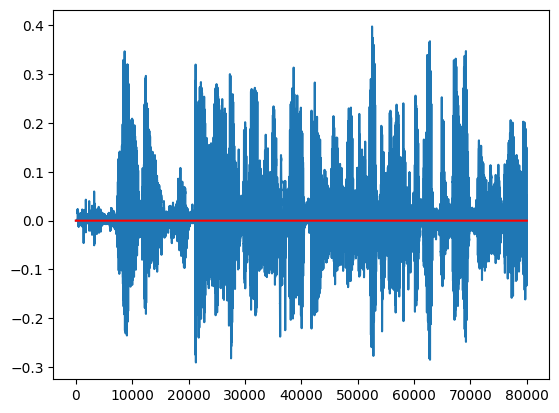

In [17]:
# The second returned expression of the VAD function is expected to be a boolean vector
# of one True or False, one per frame of the feature matrix. You can see the output of it and verify 
# if it's doing what is expected (removing low energy features) 
# raise CheckThisCell ## <---- Remove this after completeing/checking this cell

from functools import reduce

mfcc_wo_vad, vad = compute_vad(mfcc,y=audio)
plt.plot(audio[:5*16000])
plt.plot(reduce(lambda a,b:a+b, ((0.3,)*160 if s else (0,)*160 for s in vad[:500])), 'r')


You can keep testing using an audio file with different configurations of the feature extraction Inspect the dimensions, verify that your code is doing what is expected, inspect and visualize the data using the previous examples and some of the lessons learnt in LAB1. You can also listen to some examples.

In [ ]:
raise CheckThisCell ## <---- Remove this after completeing/checking this cell

audio_file = f'{DATADIR}/train100/audio/train_0005.wav'
mfcc_sdc, _ = feat_extract(audio_file, apply_cmvn=False, apply_sdc=True)
mfcc_dd, _ = feat_extract(audio_file, apply_cmvn=False, delta_order=2)
mfcc_d, _ = feat_extract(audio_file, apply_cmvn=False, delta_order=1)
mfcc, _ = feat_extract(audio_file, apply_cmvn=False)


In [ ]:
import IPython
IPython.display.Audio(audio_file)

Once you are done completing the additional modules, you can rerun the feature extraction process for the training set using new configurations. You can add new entries to the dictionary keeping several transformation configurations and instantiate the ETS class:

In [ ]:
raise CheckThisCell ## <---- Remove this after completeing/checking this cell


## <--- YOU CAN ADD NEW CONFIGURATIONS
transform ['mfcc39_d_dd_vad_cmvn'] =  { 
                     'audio_transform': lambda x : feat_extract(x, orig_sr=16000, mono=True, n_mfcc = 13, delta_order=2, apply_sdc=False, apply_vad=True, apply_cmvn=True)[0],
                     'chunk_transform': None, 
                     'chunk_size': -1, # <--- a negative value means the whole file: we dont chunk the audio and
                                       #      we compute a feature vector for each complete audio file
                     'chunk_hop': -1
                 }
            
transform['mfcc_sdc_vad_cmvn'] = { 
                     'audio_transform': lambda x : feat_extract(x, orig_sr=16000, mono=True, n_mfcc = 7, apply_sdc=True, apply_vad=True, apply_cmvn=True)[0],
                     'chunk_transform': None,
                     'chunk_size': -1, 
                     'chunk_hop':-1
                }
              
trainset = 'train100'
# transform_id = 'mfcc39_d_dd_vad_cmvn' # <--- select the configuration you want to use
# transform_id = 'mfcc_sdc_vad_cmvn'
transform_id = 'mfcc13'


train_ets = ETS(DATADIR, trainset, 
                 transform_id=transform_id, 
                 audio_transform=transform[transform_id]['audio_transform'], 
                 chunk_transform=transform[transform_id]['chunk_transform'],
                 chunk_size=transform[transform_id]['chunk_size'], 
                 chunk_hop=transform[transform_id]['chunk_hop']
                )


### 1.3 GMMs for L1 modeling
The model in this baseline is extremely simple: we'll train an individual GMM model for each L1 language on top of the features that we just extracted. Later, in prediction time, given a test audio sample, we'll compute the loglikelihood obtained with each GMM model and select as the identified L1 native language the one whose model gives the highest likelihood. Let's go for it!!


In [ ]:
# IN GMM training each training sample contains more than one frame;
# so we cocatenate all data to have all training data in one array 
# and the corresponding label with same time duration


raise CheckThisCell ## <---- Remove this after completeing/checking this cell


# We will train using the following configuration
transform_id = 'mfcc13' # <--- CHANGE THIS
trainset = 'train100'   # <--- CHANGE THIS
train_ets = ETS(DATADIR, trainset, 
                 transform_id=transform_id, 
                 audio_transform=transform[transform_id]['audio_transform'], 
                 chunk_transform=transform[transform_id]['chunk_transform'],
                 chunk_size=transform[transform_id]['chunk_size'], 
                 chunk_hop=transform[transform_id]['chunk_hop']
                )

start = time.time()
train_data = []
train_labels = []
for data, label, basename in train_ets:
        train_data.append(data)
        train_labels.append(np.full(data.shape[0], label)) 

train_data = np.concatenate(train_data)
train_labels = np.concatenate(train_labels)

print(f'Finished reading all data in {time.time() - start}')

Now we have two arrays containing the complete training dataset and the corresponging reference labels. Check the sizes. You can have a look to the content of one time instant. Do some checks on the data to be sure that everything is as expected:

In [ ]:
# Check the traininig data. Notice that if you apply VAD, the size of the training data must be smaller than the complete data set. 
# Register the size in frames and in time of training data for each language

raise CheckThisCell ## <---- Remove this after completeing/checking this cell
train_data.shape, train_labels[0]

Let's go training. Again, depending of the amount of data used, the model complexity and computational resources of the machine that you're using, this can take a while. So, relax while the computer works for you!

In [ ]:
## TRAIN GMM models (ML) 
models = {}
n_gauss = 64 ### <---- LAB WORK: You can play with the amount of Gaussians and register the impact on performance

for lang in LANGUAGES:
    models[lang] = GaussianMixture(n_components=n_gauss, covariance_type='diag', max_iter=20, n_init=1, init_params='kmeans', verbose=2, verbose_interval=1)
    
for lang in LANGUAGES:
    print(f'Training model for {lang}')
    models[lang].fit(train_data[train_labels==lang])


Once the models have been trained, we can store them in disk for later usage. Again, be careful and avoid storing versions of useless models. By default, the model is stored in a folder inside the data partition folder and contains the feature extraction in the name and the date.

In [ ]:
# save models     
now = str(datetime.datetime.now()).replace(' ','_').split('.')[0]
path = Path(DATADIR) / trainset / 'models'

if not os.path.isdir(path):
    os.mkdir(path)
    
model_name = f'gmm_{transform_id}_{now}'
os.mkdir(f'{path}/{model_name}/')

filename = f'{path}/{model_name}/model.pkl'
pickle.dump(models, open(filename, 'wb'))

You can also check the `sklearn` documentation and inspect the models trained:

In [ ]:
models['GER'].means_.shape

If you later need to reload your models (because you want to use them to predict on new data), you will have to do the following:

In [ ]:
# RELOAD MODEL!?!?
# trainset = 'train100'
# transform_id = 'mfcc_sdc_vad_cmvn'
# time_label = '2024-04-13_01:40:14'

trainset = 'train100'
transform_id = 'mfcc13'
time_label = '2024-04-12_18:18:35' ## <--- CHANGE THIS ACCORSINGLY

filename = f'{DATADIR}/{trainset}/models/gmm_{transform_id}_{time_label}/model.pkl'
models = pickle.load(open(filename, 'rb'))


### 1.4 Classification of the dev set

Now that we  already have trained models, let's predict/identify the native language in new audio data and test our model!!! 

But first, we need to obtain the development partition and apply the same feature extraction  as previously (using the ETS class).

**IMPORTANT WARNING** Make sure to use the exact same feature extraction process as the one used for the train set. Otherwise, your model will be in disagreement with your evaluation data, and very likely, will not work at all.


In [ ]:

raise CheckThisCell ## <---- Remove this after completeing/checking this cell

transform_id = 'mfcc13' ## <--- CHANGE THIS?

dev_ets = ETS(DATADIR,'dev', 
                 transform_id=transform_id, 
                 audio_transform=transform[transform_id]['audio_transform'], 
                 chunk_transform=transform[transform_id]['chunk_transform'],
                 chunk_size=transform[transform_id]['chunk_size'], 
                 chunk_hop=transform[transform_id]['chunk_hop']
                )

Now, we can iterate the data and use the models for scoring. We will store data in a dictionary, with keys corresponding to each file of the development and with value a dictionary containing the features and the label.

In [ ]:
start = time.time()
dev_data = {}

for data, label, basename in dev_ets:
        if basename not in dev_data:
                dev_data[basename] = {'data':[], 'label':label}
        dev_data[basename]['data'].append(data)

## We concatenate all the frames belonging to the same filename
for basename in dev_data:
        dev_data[basename]['data'] = np.concatenate(dev_data[basename]['data'])

print(f'Finished reading all data in {time.time() - start}')

Now, we will compute the log-likelihood for every file and language model, obtain the prediction and store everything (including the filenames and the reference label) in a dictionary:

In [ ]:
start = time.time()

results_dev = {}
results_dev['ref'] =  np.empty(len(dev_data),dtype=np.int32)
results_dev['hyp'] =  np.empty(len(dev_data),dtype=np.int32)
results_dev['llhs'] = np.empty((len(dev_data), len(LANGUAGES)), dtype=np.float64)
results_dev['fileids'] = list()

for i, fileid in tqdm(enumerate(sorted(dev_data)), total=len(dev_data)):
    data = dev_data[fileid]['data']  # the features
    
    results_dev['fileids'].append(fileid)     #fileid

    # obtain the log-likelihood score for each model and store
    results_dev['llhs'][i,:] = np.array([models[lang].score(data) for lang in LANGUAGES])

    # store the reference. Notice that we only have this for the dev set, not for the eval
    results_dev['ref'][i] = (LANG2ID[dev_data[fileid]['label']]) #reference

    # Obtain the maximum likelihood nativelanguge estimation
    ix = np.argmax(results_dev['llhs'][i,:])
    results_dev['hyp'][i] = LANG2ID[LANGUAGES[ix]]
    
    
print(f'Finished predicting all data in {time.time() - start}')


We will save the results object of the development set. We will use it later to generate the final submission file:

In [ ]:
# save results
filename = f'{DATADIR}/{trainset}/models/{model_name}/dev.pkl'
pickle.dump(results_dev, open(filename, 'wb'))


### 1.5 System Evaluation
After running the previous cells, we obtained two arrays with the reference and hypothesis labels (we can also reload them in case we need them). We can use these to compute different evaluation metrics and inspect the performance (and potential problems) of our system. Of course, you will only be able to do this assessment with the development set, since you don't have access to the eval labels.

You can for instance obtain a classification report summary:

In [ ]:
ref, hyp = results_dev['ref'], results_dev['hyp']
print(classification_report(ref, hyp, target_names=LANGUAGES))

Overall accuracy (this will be the **main metric for system ranking**):

In [ ]:
accuracy_score(ref, hyp)

Or a confusion matrix: 

In [ ]:
confusion_matrix(ref, hyp)

and visualize it:

In [ ]:
conf_matrix = confusion_matrix(ref, hyp)

fig, ax = plt.subplots(figsize=(3.0, 3.0))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')

plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title(f'Confusion Matrix\n(Accuracy {100*accuracy_score(ref, hyp):.2f})', fontsize=12)
plt.show()


As a form of approximate reference, these are the accuracies that can be obtained with the following configurations using the `train100` data set:

|       |     Accuracy       |
|-------|--------------------|
| mfc13 | 0.5227272727272727 |
| mfcc39_d_dd_vad_cmvn      |  0.6761363636363636                  |
|  mfcc_sdc_vad_cmvn     |     0.7386363636363636               |   

These results are quite poor. The baseline system is very limited in several aspects (features, time context, generative model, etc.). 

### 1.6 Classification of the evl partition

Once you are happy with your system and the results obtained in the development set, you are ready to generate the predictions on the `'evl'` partition. To do that, you have to follow the same process as for the development partition, but of course, this time you will not be able to obtain performance results because you don't have labels for this partition. 

We start by instantiating the `ETS` class for the `'evl'` partition:


In [ ]:

raise CheckThisCell ## <---- Remove this after completeing/checking this cell

# RELOAD MODEL!?!?
# trainset = 'train100'
# transform_id = 'mfcc_sdc_vad_cmvn'
# time_label = '2024-04-13_01:40:14'

trainset = 'train100'
transform_id = 'mfcc13'
time_label = '2024-04-12_18:18:35' ## <--- CHANGE THIS ACCORSINGLT

filename = f'{DATADIR}/{trainset}/models/gmm_{transform_id}_{time_label}/model.pkl'
models = pickle.load(open(filename, 'rb'))


evl_ets = ETS(DATADIR,'evl', 
                 transform_id=transform_id, 
                 audio_transform=transform[transform_id]['audio_transform'], 
                 chunk_transform=transform[transform_id]['chunk_transform'],
                 chunk_size=transform[transform_id]['chunk_size'], 
                 chunk_hop=transform[transform_id]['chunk_hop']
                )


Then, we load the evaluation data:

In [ ]:
start = time.time()
evl_data = {}

for data, label, basename in evl_ets:
        if basename not in evl_data:
                evl_data[basename] = {'data':[], 'label':label}
        evl_data[basename]['data'].append(data)

for basename in evl_data:
        evl_data[basename]['data'] = np.concatenate(evl_data[basename]['data'])

print(f'Finished reading all data in {time.time() - start}')

Finally, apply the model(s) to the new `'evl'` data and safe the results for later use. 

In [ ]:
start = time.time()

results_evl = {}
results_evl['ref'] =  None
results_evl['hyp'] =  np.empty(len(evl_data),dtype=np.int32)
results_evl['llhs'] = np.empty((len(evl_data), len(LANGUAGES)), dtype=np.float64)
results_evl['fileids'] = list()


# Obtain LLH matrix
for i, fileid in tqdm(enumerate(sorted(evl_data)), total=len(evl_data)):

    data = evl_data[fileid]['data']  # the features
    results_evl['fileids'].append(fileid)     #fileid

    # obtain the log-likelihood score for each model and store
    results_evl['llhs'][i,:] = np.array([models[lang].score(data) for lang in LANGUAGES])

    # Obtain the maximum likelihood languge estimation
    ix = np.argmax(results_evl['llhs'][i,:])
    results_evl['hyp'][i] = LANG2ID[LANGUAGES[ix]]    

print(f'Finished predicting all data in {time.time() - start}')


# save results
filename = f'{DATADIR}/{trainset}/models/{model_name}/evl.pkl'
pickle.dump(results_evl, open(filename, 'wb'))

### 1.7 Submitting your system predictions to the challenge

First, you need to create the predictions file in the expected format.
The predictions file used for submission and scoring is a CSV file containing the predictions of both the `dev` and `evl` partitions.
The file has two fields: fileId and Lang. The fileId is the unique audio file identifier and the Lang field is the language prediction (numeric from 1 to 4). The predictions file name must be as follows:

`G<YY>_<SYSTEMID>.csv` 

where `<YY>` is the students' group number (use 2 digits) and `<SYSTEMID>` is an identifying string for that submission/system.

In [ ]:
trainset = 'train100' ## <--- CHANGE THIS ACCORDINGLY
transform_id = 'mfcc13' ## <--- CHANGE THIS ACCORDINGLY
time_label = '2024-04-12_18:18:35' ## <--- CHANGE THIS ACCORDINGLY

filename_dev = f'{DATADIR}/{trainset}/models/gmm_{transform_id}_{time_label}//dev.pkl'
filename_evl = f'{DATADIR}/{trainset}/models/gmm_{transform_id}_{time_label}//evl.pkl'

results_dev = pickle.load(open(filename_dev, 'rb'))
results_evl = pickle.load(open(filename_evl, 'rb'))

group, system = '00', f'baseline_train100_{transform_id}'
with open(f'{CWD}/g{group}_{system}.csv', 'w') as file:
    csv_writer = csv.writer(file) # CSV writer
    csv_writer.writerow(('fileId', 'Lang')) # Header of the CSV

    # Save dev results
    for i in range(len(results_dev['fileids'])):
        csv_writer.writerow((results_dev['fileids'][i], results_dev['hyp'][i]))
    # Save evl results
    for i in range(len(results_evl['fileids'])):
        csv_writer.writerow((results_evl['fileids'][i], results_evl['hyp'][i]))

Finally, you can submit your prediction(s) in the following [Kaggle competition](https://www.kaggle.com/t/312cd4200cfb4e138ea9372ce5bc33fd).


# Contacts and support
You can contact the professors during the classes or the office hours.

Particularly, for this second laboratory assignment, you should contact Prof. Alberto Abad: alberto.abad@tecnico.ulisboa.pt



